<a href="https://colab.research.google.com/github/BoWarburton/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/Bo_Warburton_LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [X] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [X] Begin with baselines for classification.
- [X] Use scikit-learn for logistic regression.
- [X] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [X] Get your model's test accuracy. (One time, at the end.)
- [X] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [X] Do one-hot encoding.

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [73]:
df.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,Donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,3.80,NaN,Scott,good fries: 4/5,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Oscar's Mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,3.00,NaN,Scott,Fries: 3/5; too little meat,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oscar's Mexican food,Carnitas,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,3.00,NaN,Emily,NaN,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Oscar's Mexican food,Carne asada,1/24/2016,NaN,NaN,NaN,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,3.75,NaN,Ricardo,Go to average burrito place like Rigoberto's i...,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Pollos Maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,4.20,NaN,Scott,NaN,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
df.tail()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
418,Valentine's Mexican Food,Al Pastor,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,NaN,NaN,17.0,20.5,0.57,5.0,4.0,3.5,NaN,4.0,4.0,2.0,2.0,5.0,3.5,NaN,Anon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
419,Valentine's Mexican Food,Chile Relleno,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,6.0,4.0,NaN,NaN,19.0,26.0,1.02,4.0,5.0,NaN,3.5,4.0,4.0,5.0,4.0,3.0,4.0,NaN,Bonnie,non-symmetric wrapping,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
420,Valentine's Mexican Food,California,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,7.9,3.0,NaN,NaN,20.0,22.0,0.77,4.0,4.0,4.0,3.7,3.0,2.0,3.5,4.0,4.5,3.5,NaN,Scott,way too small and not enough meat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,Valentine's Mexican Food,Shrimp,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,7.9,3.0,NaN,NaN,22.5,24.5,1.07,5.0,2.0,5.0,5.0,5.0,2.0,5.0,5.0,2.0,4.0,NaN,AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,Valentine's Mexican Food,Pollo Asado,8/27/2019,NaN,NaN,NaN,NaN,NaN,NaN,5.5,3.5,NaN,NaN,17.0,21.3,0.61,3.0,5.0,4.3,4.0,4.9,3.8,3.0,4.5,4.0,4.6,NaN,Sisi,"i wish there was some really bomb hot sauce, t...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
import numpy as np
df.describe(include=np.number)

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Queso
count,87.000000,87.000000,416.000000,420.000000,22.000000,22.000000,284.000000,282.000000,282.000000,423.000000,403.000000,409.000000,420.000000,414.000000,421.000000,398.000000,421.000000,420.000000,421.000000,0.0
mean,3.887356,4.167816,7.065216,3.496095,546.181818,0.675277,20.046901,22.131738,0.786489,3.519385,3.780397,3.622249,3.542024,3.589082,3.434086,3.372613,3.587767,3.981190,3.620887,NaN
std,0.475396,0.373698,1.503645,0.811466,144.445619,0.080468,2.084957,1.777526,0.152260,0.793301,0.980044,0.828384,0.801253,0.996292,1.069349,0.922434,0.886277,1.115803,0.755718,NaN
min,2.500000,2.900000,2.990000,0.500000,350.000000,0.560000,15.000000,17.000000,0.400000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,1.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,450.000000,0.619485,18.500000,21.000000,0.680000,3.000000,3.000000,3.000000,3.000000,3.000000,2.700000,3.000000,3.000000,3.500000,3.100000,NaN
50%,4.000000,4.200000,6.990000,3.500000,540.000000,0.658099,20.000000,22.000000,0.770000,3.500000,4.000000,3.800000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000,3.800000,NaN
75%,4.000000,4.400000,7.860000,4.000000,595.000000,0.721726,21.500000,23.000000,0.880000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.100000,NaN
max,4.500000,5.000000,25.000000,5.000000,925.000000,0.865672,26.000000,29.000000,1.540000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [78]:
df.describe(exclude=np.number)

,Location,Burrito,Date,Neighborhood,Address,URL,Chips,Rec,Reviewer,Notes,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
count,423,423,423,92,88,87,26,233,422,146,33,7,180,159,155,160,128,92,51,21,21,6,36,35,11,7,7,1,8,38,7,15,17,4,7,2,4,4,1,5,3,3,2,13,3,1
unique,108,132,169,41,87,86,4,6,106,145,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,1
top,Lucha Libre North Park,California,8/30/2016,Clairemont,9500 Gilman Dr,https://www.yelp.com/biz/el-dorado-mexican-foo...,x,Yes,Scott,Bland,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x
freq,28,101,29,9,2,2,21,157,147,2,33,5,138,128,115,129,103,67,36,20,17,4,26,27,9,5,4,1,6,33,6,9,9,3,5,2,4,4,1,5,3,3,2,13,2,1


In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [82]:
california.head(20)

0      True
1      True
2     False
3     False
4      True
5     False
6      True
7     False
8      True
9     False
10    False
11    False
12     True
13    False
14     True
15     True
16    False
17    False
18    False
19     True
Name: Burrito, dtype: bool

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [110]:
# Final cleaned df
df.describe(include=np.number)

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso
count,87.000000,87.000000,414.000000,418.000000,22.000000,22.000000,283.000000,281.000000,281.000000,421.000000,401.000000,407.000000,418.000000,412.000000,419.000000,396.000000,419.000000,418.000000,0.0
mean,3.887356,4.167816,7.067343,3.495335,546.181818,0.675277,20.038233,22.135765,0.786477,3.519477,3.783042,3.620393,3.539833,3.586481,3.428998,3.371970,3.586993,3.979904,NaN
std,0.475396,0.373698,1.506742,0.812069,144.445619,0.080468,2.083518,1.779408,0.152531,0.794438,0.980338,0.829254,0.799549,0.997057,1.068794,0.924037,0.886807,1.118185,NaN
min,2.500000,2.900000,2.990000,0.500000,350.000000,0.560000,15.000000,17.000000,0.400000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,0.000000,1.000000,0.000000,NaN
25%,3.500000,4.000000,6.250000,3.000000,450.000000,0.619485,18.500000,21.000000,0.680000,3.000000,3.000000,3.000000,3.000000,3.000000,2.600000,3.000000,3.000000,3.500000,NaN
50%,4.000000,4.200000,6.990000,3.500000,540.000000,0.658099,20.000000,22.000000,0.770000,3.500000,4.000000,3.800000,3.500000,4.000000,3.500000,3.500000,3.800000,4.000000,NaN
75%,4.000000,4.400000,7.880000,4.000000,595.000000,0.721726,21.500000,23.000000,0.880000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN
max,4.500000,5.000000,25.000000,5.000000,925.000000,0.865672,26.000000,29.000000,1.540000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN


In [111]:
df.describe(exclude=np.number)

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,421,421,26,33,7,179,158,154,159,127,92,51,21,21,6,36,35,11,7,7,1,8,38,7,15,17,4,7,2,4,4,1,5,3,3,2,13,3,1,421
unique,5,169,4,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,1,2
top,California,2016-08-30 00:00:00,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,False
freq,169,29,21,33,5,137,127,114,128,102,67,36,20,17,4,26,27,9,5,4,1,6,33,6,9,9,3,5,2,4,4,1,5,3,3,2,13,2,1,239
first,NaN,2011-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2026-04-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [0]:
from sklearn.model_selection import train_test_split
import pandas as pd
import datetime as dt
# Convert date column to Pandas datetime to split
# Note to self, here are other ways to split based on date:
# df = df.set_index(df['Date'])
# df = df.sort_index()
# train = df[:'2016-12-31']
# val = df['2017-01-01':'2017-12-31']
# test  = df['2018-01-01':]
# train = df.loc[df['Date'] <= '2016-12-31']
# test = df.loc[df['Date'] >= '2018-01-01']


In [0]:
df['Date'] = pd.to_datetime(df['Date'])

In [87]:
df.dtypes

Burrito                   object
Date              datetime64[ns]
Yelp                     float64
Google                   float64
Chips                     object
Cost                     float64
Hunger                   float64
Mass (g)                 float64
Density (g/mL)           float64
Length                   float64
Circum                   float64
Volume                   float64
Tortilla                 float64
Temp                     float64
Meat                     float64
Fillings                 float64
Meat:filling             float64
Uniformity               float64
Salsa                    float64
Synergy                  float64
Wrap                     float64
Unreliable                object
NonSD                     object
Beef                      object
Pico                      object
Guac                      object
Cheese                    object
Fries                     object
Sour cream                object
Pork                      object
Chicken   

In [0]:
target = 'Great'
train = df[df['Date'].dt.year <= 2016]
val = df[df['Date'].dt.year == 2017]
test = df[df['Date'].dt.year >= 2018]

In [149]:
train.shape, val.shape, test.shape

((298, 59), (85, 59), (38, 59))

In [150]:
train.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [151]:
test.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
77,California,2026-04-25,NaN,NaN,NaN,8.00,4.0,NaN,NaN,21.59,NaN,NaN,4.5,5.0,5.0,5.0,4.5,5.0,3.0,5.0,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
386,California,2018-01-02,NaN,NaN,NaN,7.25,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,5.0,5.0,3.0,3.0,4.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
387,Other,2018-01-09,4.5,3.8,NaN,4.19,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,2.0,2.0,4.0,1.0,4.0,3.0,4.0,x,NaN,NaN,NaN,NaN,x,NaN,x,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,False
388,California,2018-01-12,3.5,4.3,NaN,7.00,5.0,NaN,NaN,NaN,NaN,NaN,5.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,5.0,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
389,Other,2018-01-12,NaN,NaN,NaN,8.50,4.0,NaN,NaN,21.00,23.5,0.92,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [152]:
val.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
301,California,2017-01-04,NaN,NaN,NaN,6.60,NaN,NaN,NaN,23.0,20.5,0.77,4.0,4.5,4.0,3.5,3.5,5.0,1.5,3.50,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
302,Other,2017-01-04,NaN,NaN,NaN,6.60,NaN,NaN,NaN,20.5,21.5,0.75,4.0,2.0,NaN,4.0,NaN,4.6,4.2,3.75,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
303,Other,2017-01-07,NaN,NaN,NaN,8.50,3.9,NaN,NaN,21.0,21.0,0.74,3.0,4.5,4.1,3.0,3.7,4.0,4.3,4.20,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
304,Other,2017-01-07,NaN,NaN,NaN,7.90,4.0,NaN,NaN,20.5,21.0,0.72,3.5,4.0,4.0,3.0,4.0,4.5,4.0,3.80,4.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
305,Other,2017-01-10,NaN,NaN,NaN,4.99,3.5,NaN,NaN,18.5,22.5,0.75,2.5,4.5,3.0,2.5,3.0,3.0,2.0,2.00,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [153]:
# Note to self: what features am I going to use?
# Which is more of a question than a note to self.
# As I go through this again, I want to use pandas profiling

# and...after looking at the correlations, I think I'll try
# synergy, meat, fillings, and temp at the very last go

import pandas_profiling
pandas_profiling.ProfileReport(train)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,60
Number of observations,298
Total Missing (%),65.1%
Total size in memory,137.8 KiB
Average record size in memory,473.4 B
Numeric,17
Categorical,38
Boolean,1
Date,1
Text (Unique),0
Rejected,3


Begin with baseline for classification

In [99]:
train[target].value_counts()

False    176
True     122
Name: Great, dtype: int64

In [109]:
baseline = train[target].value_counts()[1] / (train[target].value_counts()[0] + train[target].value_counts()[1])
print(f'Baseline is overall % of burritos called great: {(baseline*100):.2f}%')

Baseline is overall % of burritos called great: 40.94%


Use scikit-learn for logistic regression

In [0]:
# Features, for 1st go just use numeric
features = ['Yelp', 'Google', 'Cost', 'Hunger', 'Mass (g)',
            'Density (g/mL)', 'Length', 'Circum', 'Volume',
            'Tortilla', 'Temp', 'Meat', 'Fillings',
            'Meat:filling', 'Uniformity', 'Salsa', 'Synergy',
            'Wrap', 'Queso']
X_train = train[features]
X_val = val[features]
y_train = train[target]
y_val = val[target]

In [0]:
# Import libraries
from sklearn.linear_model import LogisticRegression


In [0]:
# (1) Impute (2) Scale (3) Fit
# Impute
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

In [0]:
# Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [0]:
# Fit
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=59)
model.fit(X_train_scaled, y_train)
accuracy = model.score(X_val_scaled, y_val)

In [122]:
print(f'Accuracy: {accuracy*100:.2f}%')

Accuracy: 88.24%


88.23% accuracy. Much better than baseline.

In [123]:
# One-hot encoding
# Add some categorical features to X_train, etc.
# Then encode before impute - scale - fit
# Add some categorical features (type object, string)
import category_encoders as ce
features = features + ['Chicken', 'Shrimp', 'Rice', 'Beans', 'Lettuce', 'Onion']
features

['Yelp',
 'Google',
 'Cost',
 'Hunger',
 'Mass (g)',
 'Density (g/mL)',
 'Length',
 'Circum',
 'Volume',
 'Tortilla',
 'Temp',
 'Meat',
 'Fillings',
 'Meat:filling',
 'Uniformity',
 'Salsa',
 'Synergy',
 'Wrap',
 'Queso',
 'Chicken',
 'Shrimp',
 'Rice',
 'Beans',
 'Lettuce',
 'Onion']

In [0]:
X_train_enc = train[features]
X_test_enc = test[features]
X_val_enc = val[features]

In [0]:
# encode
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train_enc)
X_val_encoded = encoder.transform(X_val_enc)

In [0]:
# impute
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

In [0]:
# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [128]:
# fit
model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                     random_state=42, refit=True, scoring=None, solver='lbfgs',
                     tol=0.0001, verbose=0)

In [0]:
accuracy = model.score(X_val_scaled, y_val)

In [130]:
print(f'Accuracy after one-hot: {accuracy*100:.2f}%')

Accuracy after one-hot: 80.00%


80% - It got worse!

Get your model's test accuracy. (One time, at the end.) Commit your notebook to your fork of the GitHub repo.

Get validation accuracy going back to original

In [0]:
# Redo the training process with many fewer features based on instinct
# (1) choose features
# (2) impute on training data
# (3) scale on training data
# (4) fit on training data

# synergy, fillings, meat

features = ['Yelp', 'Google', 'Cost', 'Hunger', 'Temp',
            'Uniformity', 'Synergy']

In [0]:
# impute
X_train = train[features]
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)

In [0]:
# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

In [0]:
# fit
model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train);

In [135]:
# NOW test
X_test = test[features]
y_test = test[target]

X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
print(f'Test Accuracy: {model.score(X_test_scaled, y_test)*100:.2f}%')

Test Accuracy: 78.95%


In [0]:
# What?!

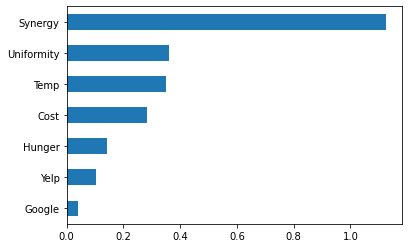

In [137]:
%matplotlib inline
coefficients = pd.Series(model.coef_[0], features)
coefficients.sort_values().plot.barh();

In [0]:
# So now I want to try it with just Synergy
features = ['Synergy', 'Meat', 'Fillings', 'Temp']

In [0]:
# impute
X_train = train[features]
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)

In [0]:
# scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

In [0]:
# fit
model = LogisticRegressionCV(cv=5, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train);

In [159]:
# NOW test
X_test = test[features]
y_test = test[target]

X_test_imputed = imputer.transform(X_test)
X_test_scaled = scaler.transform(X_test_imputed)
print(f'Test Accuracy: {model.score(X_test_scaled, y_test)*100:.2f}%')

Test Accuracy: 73.68%


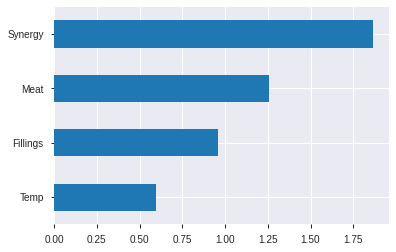

In [160]:
%matplotlib inline
coefficients = pd.Series(model.coef_[0], features)
coefficients.sort_values().plot.barh();